In [1]:
import h5py
import json
import numpy as np
import os
import sys
from matplotlib import pyplot as plt

# rootFolder = '/home/fernando/S1_BBP/'
rootFolder = os.getcwd()
print(rootFolder)
folder = os.listdir('cell_data/')
folder = sorted(folder)

savedata = 1 # Save Netpyne and BBP soma_voltage

/home/fernando/S1_BBP


In [2]:
folder[265:270]

['L23_PC_cADpyr229_1',
 'L23_PC_cADpyr229_2',
 'L23_PC_cADpyr229_3',
 'L23_PC_cADpyr229_4',
 'L23_PC_cADpyr229_5']

In [3]:
def loadTemplateName(cellnumber):     
    f = open(outFolder+'/template.hoc', 'r')
    for line in f.readlines():
        if 'begintemplate' in line:
            templatename = str(line)     
    templatename=templatename[:-1]        
    templatename=templatename[14:]
    return templatename

In [4]:
def runneuron(cellnumber):
        
    os.chdir(rootFolder)
    
    cellName = folder[cellnumber]
    cellTemplateName = loadTemplateName(cellnumber)

    from cellwrapper3 import loadCell
    cell=loadCell(cellName, cellTemplateName)

    soma = cell.soma[0]

    BBPTraces = []
    BBPTracesList = []
    
    i=0
    for x in current_content.split():
        i=i+1   

        stimulus = neuron.h.IClamp(0.5, sec=soma)
        stimulus2 = neuron.h.IClamp(0.5, sec=soma)

        stimulus.dur = durationstim # ms
        stimulus.delay = delaystim  # ms     
        stimulus2.dur = timesimulation # ms
        stimulus2.delay = 0  # ms    
        
        if float(x)<0:
            stimulus.amp = float(x)
            stimulus2.amp = 0
        else:
            stimulus.amp = float(x)
            stimulus2.amp = holding_current

        recordings = {}

        recordings['time'] = neuron.h.Vector()
        recordings['soma(0.5)'] = neuron.h.Vector()

        recordings['time'].record(neuron.h._ref_t, 0.1)
        recordings['soma(0.5)'].record(cell.soma[0](0.5)._ref_v, 0.1)

        neuron.h.dt = 0.05
        neuron.h.cvode_active(0)
        neuron.h.tstop = timesimulation # ms
        neuron.h.run();

        time = np.array(recordings['time'])
        soma_voltage = np.array(recordings['soma(0.5)'])

        BBPTraces.append(soma_voltage)
        BBPTracesList.append(list(soma_voltage))
    
    return BBPTraces

In [5]:
def runneuron2(cellnumber):
        
    os.chdir(rootFolder)
    
    cellName = folder[cellnumber]
    cellTemplateName = loadTemplateName(cellnumber)

    from cellwrapper2 import loadCell
    cell=loadCell(cellName, cellTemplateName)

    soma = cell.soma[0]

    BBPTraces2 = []
    BBPTracesList2 = []

    i=0
    for x in current_content.split():
        i=i+1   
        
        stimulus = neuron.h.IClamp(0.5, sec=soma)
        stimulus2 = neuron.h.IClamp(0.5, sec=soma)

        stimulus.dur = durationstim # ms
        stimulus.delay = delaystim  # ms     
        stimulus2.dur = timesimulation # ms
        stimulus2.delay = 0  # ms    
        
        if float(x)<0:
            stimulus.amp = float(x)
            stimulus2.amp = 0
        else:
            stimulus.amp = float(x)
            stimulus2.amp = holding_current

        recordings = {}

        recordings['time'] = neuron.h.Vector()
        recordings['soma(0.5)'] = neuron.h.Vector()

        recordings['time'].record(neuron.h._ref_t, 0.1)
        recordings['soma(0.5)'].record(cell.soma[0](0.5)._ref_v, 0.1)

        neuron.h.dt = 0.05
        neuron.h.cvode_active(0)
        neuron.h.tstop = timesimulation # ms
        neuron.h.run();

        time = np.array(recordings['time'])
        soma_voltage = np.array(recordings['soma(0.5)'])

        BBPTraces2.append(soma_voltage)
        BBPTracesList2.append(list(soma_voltage))
    return BBPTraces2

In [6]:
def runnetpyne(cellnumber):

    os.chdir(rootFolder)
    from netpyne import sim
    from netpyne import specs
    import pickle

    cfg = specs.SimConfig()     
    
    cfg.duration = timesimulation ## Duration of the sim, in ms  
    cfg.dt = 0.05
    # ~ cfg.seeds = {'conn': 4321, 'stim': 1234, 'loc': 4321} 
    cfg.hParams = {'celsius': 34, 'v_init': -65}  
    cfg.verbose = False
    cfg.createNEURONObj = True
    cfg.createPyStruct = True
    cfg.cvode_active = False
    cfg.cvode_atol = 1e-6
    cfg.cache_efficient = True
    cfg.printRunTime = 0.5
    
    cfg.includeParamsLabel = False
    cfg.printPopAvgRates = True
    cfg.checkErrors = False
    
    allpops = ['L1_1','L1_2','L1_3','L1_4']

    cfg.recordCells = allpops  # which cells to record from
    cfg.recordTraces = {'V_soma': {'sec':'soma_0', 'loc':0.5, 'var':'v'}}  ## Dict with traces to record
    cfg.recordStim = True
    cfg.recordTime = True
    cfg.recordStep = 0.1            

    cfg.simLabel = 'S1detailed'
    cfg.saveFolder = '.'
    # cfg.filename =                	## Set file output name
    cfg.savePickle = False         	## Save pkl file
    cfg.saveJson = False           	## Save json file
    cfg.saveDataInclude = ['simConfig', 'netParams'] ## 'simData' , 'simConfig', 'netParams'
    cfg.backupCfgFile = None 		##  
    cfg.gatherOnlySimData = False	##  
    cfg.saveCellSecs = False			##  
    cfg.saveCellConns = False		##  

    #------------------------------------------------------------------------------
    # Analysis and plotting 
    #------------------------------------------------------------------------------
    # ~ cfg.analysis['plotTraces'] = {'include': [('L1_1',0)], 'saveFig': True, 'showFig': False, 'oneFigPer':'trace', 'overlay':False} 		
    #------------------------------------------------------------------------------
    # Cells
    #------------------------------------------------------------------------------
    cfg.cellmod =  {'L1_1': 'HH_full'}
    cfg.cellmod =  {'L1_2': 'HH_full'}
    cfg.cellmod =  {'L1_3': 'HH_full'}
    cfg.cellmod =  {'L1_4': 'HH_full'}

    #------------------------------------------------------------------------------
    # Current inputs 
    #------------------------------------------------------------------------------
    cfg.addIClamp = 1

    cfg.IClamp1 = {'pop': 'L1_1', 'sec': 'soma_0', 'loc': 0.5, 'start': delaystim, 'dur': durationstim, 'amp': holding_current}
    cfg.IClamp2 = {'pop': 'L1_2', 'sec': 'soma_0', 'loc': 0.5, 'start': 0, 'dur': timesimulation, 'amp': holding_current}
    cfg.IClamp3 = {'pop': 'L1_2', 'sec': 'soma_0', 'loc': 0.5, 'start': delaystim, 'dur': durationstim, 'amp': step1_current}
    cfg.IClamp4 = {'pop': 'L1_3', 'sec': 'soma_0', 'loc': 0.5, 'start': 0, 'dur': timesimulation, 'amp': holding_current}
    cfg.IClamp5 = {'pop': 'L1_3', 'sec': 'soma_0', 'loc': 0.5, 'start': delaystim, 'dur': durationstim, 'amp': step2_current}
    cfg.IClamp6 = {'pop': 'L1_4', 'sec': 'soma_0', 'loc': 0.5, 'start': 0, 'dur': timesimulation, 'amp': holding_current}
    cfg.IClamp7 = {'pop': 'L1_4', 'sec': 'soma_0', 'loc': 0.5, 'start': delaystim, 'dur': durationstim, 'amp': step3_current}


    netParams = specs.NetParams()   # object of class NetParams to store the network parameters

    #------------------------------------------------------------------------------
    # Cell parameters
    #------------------------------------------------------------------------------

    cellName = folder[cellnumber]
    cellTemplateName = loadTemplateName(cellnumber)
    cellRule = netParams.importCellParams(label=cellName + '_rule', somaAtOrigin=False,
        conds={'cellType': cellName, 'cellModel': 'HH_full'},
        fileName='cellwrapper3.py',
        cellName='loadCell',
        cellInstance = True,
        cellArgs={'cellName': cellName, 'cellTemplateName': cellTemplateName})

    #------------------------------------------------------------------------------
    # Population parameters
    #------------------------------------------------------------------------------

    netParams.popParams['L1_1'] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 
    netParams.popParams['L1_2'] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 
    netParams.popParams['L1_3'] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 
    netParams.popParams['L1_4'] = {'cellType': cellName, 'cellModel': 'HH_full', 'numCells': 1} 

    #------------------------------------------------------------------------------
    # Current inputs (IClamp)
    #------------------------------------------------------------------------------
    if cfg.addIClamp:
         for key in [k for k in dir(cfg) if k.startswith('IClamp')]:
            params = getattr(cfg, key, None)
            [pop,sec,loc,start,dur,amp] = [params[s] for s in ['pop','sec','loc','start','dur','amp']]

            #cfg.analysis['plotTraces']['include'].append((pop,0))  # record that pop

            # add stim source
            netParams.stimSourceParams[key] = {'type': 'IClamp', 'delay': start, 'dur': dur, 'amp': amp}

            # connect stim source to target
            netParams.stimTargetParams[key+'_'+pop] =  {
                'source': key, 
                'conds': {'pop': pop},
                'sec': sec, 
                'loc': loc}

    sim.createSimulateAnalyze(netParams, cfg)
    
    netpyneTraces = []
    netpyneTracesList = []
    for c in range(0,4):
        netpyneTraces.append(np.array(sim.simData['V_soma']['cell_'+ str(c)]))
        netpyneTracesList.append(list(sim.simData['V_soma']['cell_'+ str(c)]))        
 
    return netpyneTraces

CellNumber = 916
CellName = L6_MC_bIR215_2
TemplateName = bIR215_L6_MC_d379cda689
load step1_current from current_amps.dat = 0.1430628
Loading constants
Setting temperature to 34.000000 C
Setting simulation time step to 0.025000 ms
	1 
	1 
	1 
Loading cell bIR215_L6_MC_d379cda689
bIR215_L6_MC_d379cda689[0]
Changed dt
Changed dt
Changed dt
Changed dt
bIR215_L6_MC_d379cda689[0]
Changed dt
Changed dt
Changed dt
Changed dt
bIR215_L6_MC_d379cda689[0]

Start time:  2021-07-02 00:35:44.966714

Creating network of 4 cell populations on 1 hosts...
  Number of cells on node 0: 4 
  Done; cell creation time = 0.21 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
Adding stims...
  Number of stims on node 0: 7 
  Done; cell stims creation time = 0.00 s.
Recording 8 traces of 2 types on node 0
0.0s

Running simulation for 3000.0 ms...
0.5s
1.0s
1.5s
2.0s
2.5s
3.0s
  Done; run time = 49.14 s; real-time ratio: 0.06.

Gathering data...
  Done; gather

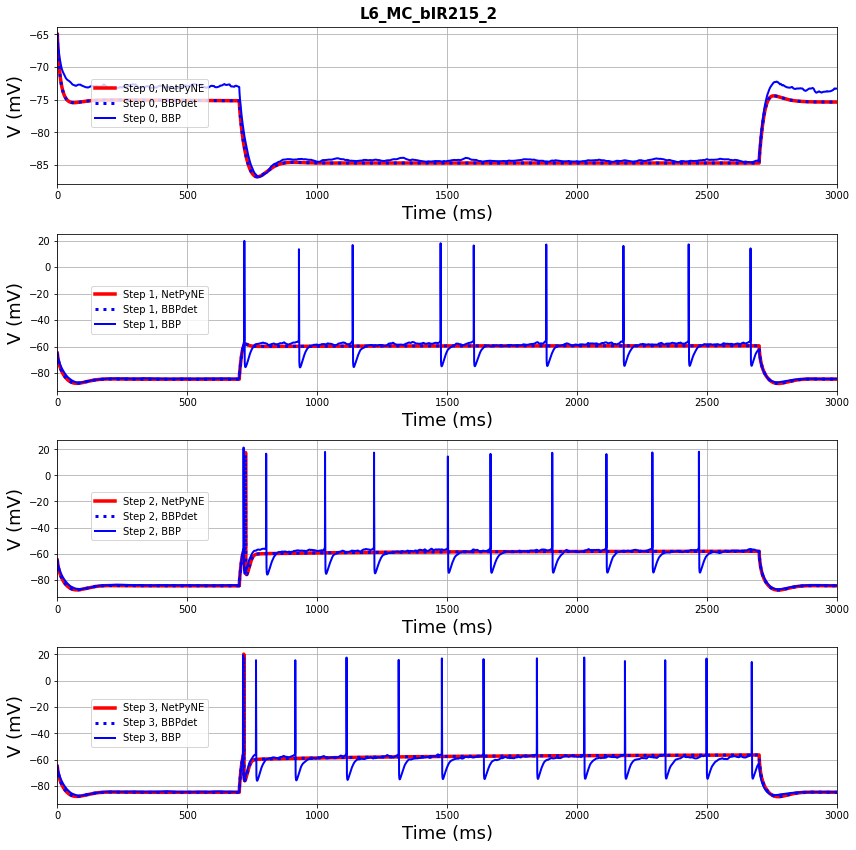

In [7]:
cellnumber = 916 #369 # 267
cellName = folder[cellnumber]
outFolder = rootFolder+'/cell_data/'+folder[cellnumber]
cellTemplateName = loadTemplateName(cellnumber)
print ("CellNumber = %d" % cellnumber)
print ("CellName = %s" % cellName)
print ("TemplateName = %s" % cellTemplateName)

with open(outFolder + '/current_amps.dat') as current_file:
    current_content = current_file.read()

holding_current, step1_current, step2_current, step3_current = [float(x) for x in current_content.split()]
print ('load step1_current from current_amps.dat = %s' % step1_current)
        
durationstim = 2000
delaystim = 700
timesimulation = 3000
        
# durationstim = 400
# delaystim = 200
# timesimulation = 700

BBPTraces2 = runneuron2(cellnumber)
BBPTraces = runneuron(cellnumber)
netpyneTraces = runnetpyne(cellnumber)
# plot both traces overlayed
fontsiz=18
timeRange = [0, timesimulation]
recordStep = 0.1
# ~ ylim = [-100, 40]
figSize = (12,12)
fig = plt.figure(figsize=figSize)  # Open a new figure

fig.suptitle('%s' % (cellName), fontsize=15, fontweight='bold')
                
t = np.arange(timeRange[0], timeRange[1]+recordStep, recordStep) 
 
for c in range(0,4):
    netpyneTrace = netpyneTraces[c]
    BBPTrace = BBPTraces[c]
    BBPTrace2 = BBPTraces2[c]
    plt.subplot(4, 1, c+1)
    plt.ylabel('V (mV)', fontsize=fontsiz)
    plt.plot(t[:len(netpyneTrace)], netpyneTrace, linewidth=3.5, color='red', label='Step %d'%(int(c+0))+', NetPyNE')
    plt.plot(t[:len(BBPTrace)], BBPTrace, linewidth=3.0, linestyle=':', color='blue', label='Step %d'%(int(c+0))+', BBPdet')  # linestyle=':'
    plt.plot(t[:len(BBPTrace2)], BBPTrace2, linewidth=2.0, color='blue', label='Step %d'%(int(c+0))+', BBP')  # linestyle=':'
    plt.xlabel('Time (ms)', fontsize=fontsiz)
    plt.xlim(0, timesimulation)
    # ~ plt.ylim(ylim)
    plt.grid(True)
    plt.legend(loc='upper right', bbox_to_anchor=(0.20, 0.7))
plt.ion()
plt.tight_layout()

plt.savefig(rootFolder+'/comparison_traces_soma_voltage_4steps_%s.png' % cellName)
print ("Figure Saved in %s/comparison_traces_soma_voltage_4steps_%s.png" % (rootFolder,cellName))
print ("https://bbp.epfl.ch/nmc-portal/microcircuit.html#/metype/%s/details" % cellName[:-5])
plt.show()

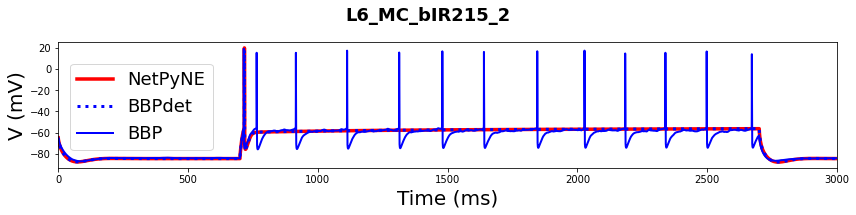

In [8]:
fontsiz=20
timeRange = [0, timesimulation]
recordStep = 0.1
# ~ ylim = [-100, 40]
figSize = (12,3)
fig = plt.figure(figsize=figSize)  # Open a new figure

fig.suptitle('%s' % (cellName), fontsize=18, fontweight='bold')
                
t = np.arange(timeRange[0], timeRange[1]+recordStep, recordStep) 

c = 3
netpyneTrace = netpyneTraces[c]
BBPTrace = BBPTraces[c]
BBPTrace2 = BBPTraces2[c]
plt.ylabel('V (mV)', fontsize=fontsiz)
plt.plot(t[:len(netpyneTrace)], netpyneTrace, linewidth=3.5, color='red', label='NetPyNE')
plt.plot(t[:len(BBPTrace)], BBPTrace, linewidth=3.0, linestyle=':', color='blue', label='BBPdet')  # linestyle=':'
plt.plot(t[:len(BBPTrace2)], BBPTrace2, linewidth=2.0, color='blue', label='BBP')  # linestyle=':'

plt.xlim(0, timesimulation)
# ~ plt.ylim(ylim)
plt.grid(False)
plt.legend(loc='upper right', bbox_to_anchor=(0.21, 0.9), fontsize=18)
plt.xlabel('Time (ms)', fontsize=fontsiz)
plt.ion()
plt.tight_layout()

plt.savefig(rootFolder+'/comparison_traces_soma_voltage_4steps_%s.png' % cellName, dpi=300, facecolor = 'white', bbox_inches='tight')
plt.show()

In [9]:
folder[915:935]

['L6_MC_bIR215_1',
 'L6_MC_bIR215_2',
 'L6_MC_bIR215_3',
 'L6_MC_bIR215_4',
 'L6_MC_bIR215_5',
 'L6_MC_bNAC219_1',
 'L6_MC_bNAC219_2',
 'L6_MC_bNAC219_3',
 'L6_MC_bNAC219_4',
 'L6_MC_bNAC219_5',
 'L6_MC_bSTUT213_1',
 'L6_MC_bSTUT213_2',
 'L6_MC_bSTUT213_3',
 'L6_MC_bSTUT213_4',
 'L6_MC_bSTUT213_5',
 'L6_MC_cACint209_1',
 'L6_MC_cACint209_2',
 'L6_MC_cACint209_3',
 'L6_MC_cACint209_4',
 'L6_MC_cACint209_5']